#                                                                           Harris Corner Detection


In [257]:
import cv2
import os 
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import convolve


# Gaussian Function

In [258]:
def gaus(size, sigma):
    center = size // 2
    gaussian = np.zeros((size, size))

    for i in range(size):
        for j in range(size):
            x = i - center
            y = j - center
            gaussian[i, j] = np.exp(-((x ** 2 + y ** 2) / (2 * sigma ** 2)))

    # Normalize the Gaussian kernel
    gaussian /= np.sum(gaussian)
    return gaussian

# Gradients

In [259]:
def compute_gradients(image):
     I_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)  # Gradient in X direction
     I_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)  # Gradient in Y direction

     return I_x, I_y

# Structure Tensor

In [260]:
def compute_structure_tensor(I_x_smooth, I_y_smooth):
    I_x2 = I_x_smooth ** 2
    I_y2 = I_y_smooth ** 2
    I_xy = I_x_smooth * I_y_smooth
    return I_x2, I_y2, I_xy

# Applying Window

In [261]:
def apply_window(I_x2, I_y2, I_xy, size, sigma):
    gaussian_kernel = gaus(size, sigma)  # Create custom Gaussian kernel
    w_x2 = convolve(I_x2, gaussian_kernel)
    w_y2 = convolve(I_y2, gaussian_kernel)
    w_xy = convolve(I_xy, gaussian_kernel)
    return w_x2, w_y2, w_xy

# Corner Response

In [262]:
def compute_corner_response(w_x2, w_y2, w_xy, k):
    det_M = w_x2 * w_y2 - w_xy**2
    trace_M = w_x2 + w_y2
    R = det_M - k * (trace_M**2)
    return R

# Thresholding

In [263]:
def apply_threshold(R, threshold_ratio):
    R_max = np.max(R)
    threshold = threshold_ratio * R_max
    R[R < threshold] = 0
    return R

# Non maxima supression

In [264]:
def non_max_suppression(R, window_size=7):
    
    suppressed_R = np.zeros_like(R)
    
    for i in range(window_size, R.shape[0] - window_size):
        for j in range(window_size, R.shape[1] - window_size):
            window = R[i-window_size:i+window_size+1, j-window_size:j+window_size+1]
            if R[i, j] == np.max(window):
                suppressed_R[i, j] = R[i, j]
    
    return suppressed_R

# Corner Plotting

In [273]:
def plot_image_with_corners(image, corners, output_path):
    # Convert grayscale image to RGB for correct color plotting in matplotlib
    rgb_image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    
    # Get the original image dimensions
    height, width = image.shape[:2]
    
    # Calculate figsize in inches based on the image size and DPI
    dpi = 100  # Dots per inch
    figsize = (width / dpi, height / dpi)
    
    # Create a figure with the size of the original image
    plt.figure(figsize=figsize, dpi=dpi)
    
    # Plot the image
    plt.imshow(rgb_image)
    
    # Overlay red markers on the corner locations
    y_coords, x_coords = corners[:, 0], corners[:, 1]
    plt.scatter(x_coords, y_coords, c='red', s=5, marker='o')  # 's' is the size of the marker
    
    # Customize and display the plot
    plt.axis('off')  # Hide axis
    plt.title('Image with Detected Corners')
    
    # Save the image with the same dimensions as the original
    plt.savefig(output_path, bbox_inches='tight', pad_inches=0, dpi=1.5*dpi)
    plt.close()

# Harris Corner Responce

In [266]:
def harris_corner_detection(image_path, k=0.06, threshold_ratio=0.01, size=5, sigma=1):
    # Step 1: Load the original image and convert to grayscale
    # The original image is loaded and converted to grayscale to simplify the corner detection process.
    image_org= cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

    # Create a custom Gaussian kernel using the specified size and sigma values
    # The Gaussian kernel is used to smooth the image, reducing noise before gradient computation.
    gaussian_kernel = gaus(size, sigma)
    
    # Apply Gaussian smoothing to the original image
    # This step smooths the entire image before gradient computation.
    image = convolve(image_org, gaussian_kernel)
    
    # Step 2: Compute gradients in the x and y directions using Sobel operator
    # This calculates the first derivatives of the image, essential for computing the structure tensor.
    I_x, I_y = compute_gradients(image)
    
    # Step 3: Compute the structure tensor elements
    # I_x2 = I_x^2, I_y2 = I_y^2, I_xy = I_x * I_y
    # These elements represent the gradient information in a matrix form.
    I_x2, I_y2, I_xy = compute_structure_tensor(I_x, I_y)
    
    # Apply Gaussian windowing to the structure tensor elements
    # This step uses a Gaussian window to smooth the elements of the structure tensor.
    w_x2, w_y2, w_xy = apply_window(I_x2, I_y2, I_xy, size, sigma)
    
    # Step 4: Compute the Harris corner response R
    # The corner response is computed using the determinant and trace of the structure tensor matrix.
    R = compute_corner_response(w_x2, w_y2, w_xy, k=k)
    
    # Step 5: Apply a threshold to the corner response
    # This removes weak corner responses by setting them to zero.
    R= apply_threshold(R, threshold_ratio=threshold_ratio)
    
    # Step 6: Apply non-maximum suppression to the thresholded response
    # This step keeps only the local maxima, which represent the strongest corners.
    R_sup = non_max_suppression(R)
    
    # Step 7: Extract corner points from the suppressed response
    # Corners are identified as non-zero points in the suppressed response matrix.
    corners = np.argwhere(R_sup> 0)
    
    return image_org,R,corners



# Image Count

In [267]:
def count_images_in_folder(folder_path, image_extensions=('.jpg', '.jpeg', '.png', '.bmp', '.gif')):
    count = 0
    for file in os.listdir(folder_path):
        if file.endswith(image_extensions):
            count += 1
    return count

In [268]:
def process_images(input_folder, output_folder):
  
    
    # Create the output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # List all image files in the input folder
    image_files =  os.listdir(input_folder) 

    # Loop through all the images
    for i in image_files:
        image_path= os.path.join(input_folder, i)
        image=cv2.imread(image_path)
        # Check if the image was successfully loaded
        if image is None:
            print(f"Error loading image at {image}")
            continue
        
        # Apply Harris corner detection
        image,R,corners = harris_corner_detection(image_path)
        
        output_path = os.path.join(output_folder, f'image_{i}_harris.jpg')
        
        # Save the processed image to the output folder
        plot_image_with_corners(image, corners,output_path)

# Video Creation

In [269]:
def create_video_from_images(image_folder, output_video_path, fps):
    # Get a list of all image files in the folder (sorted by filename)
    image_files = [f for f in sorted(os.listdir(image_folder)) if f.endswith(('png', 'jpg', 'jpeg', 'bmp'))]
    
    # Read the first image to get the dimensions
    first_image_path = os.path.join(image_folder, image_files[0])
    first_image = cv2.imread(first_image_path)
    height, width, layers = first_image.shape
    
    # Initialize the VideoWriter
    video_writer = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))
    
    # Add each image as a frame to the video
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = cv2.imread(image_path)
        video_writer.write(image)
    
    # Release the VideoWriter
    video_writer.release()
    print(f"Video saved at {output_video_path}")

# Main Funtions

In [274]:
input_folder = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\images'

output_folder = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\output_images'

output_video_file = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\output_video.mp4'

count=count_images_in_folder(input_folder)

print("No of images in the folder:\n",count)

process_images(input_folder, output_folder)

create_video_from_images(output_folder, output_video_file, fps=30)

Video saved at U:\Final Year Project\FYP-2\Tasks\Feature Extraction\CV_Assignment_1_CornerTracker\output_video.mp4


# Commands

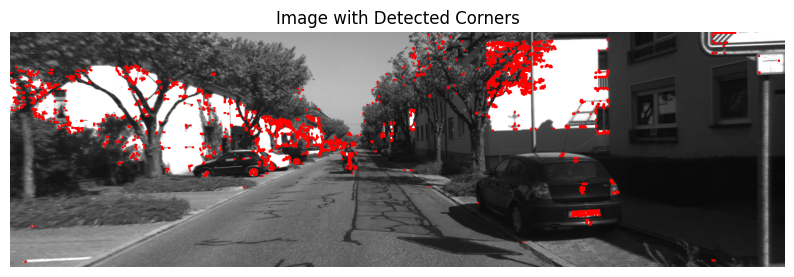

In [271]:
input_image_path = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\images\\000000.png'
output_image_path = 'U:\\Final Year Project\\FYP-2\\Tasks\\Feature Extraction\\CV_Assignment_1_CornerTracker\\out_images\\000000_hc.png'

image = cv2.imread(input_image_path)

# Convert the image to grayscale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray_image = np.float32(gray_image)

# Perform Harris corner detection
corners = cv2.cornerHarris(gray_image, blockSize=2, ksize=3, k=0.06)

# Dilate the result to enhance corner points
corners = cv2.dilate(corners, None)

# Mark corners in red on the original image
image[corners > 0.01 * corners.max()] = [0, 0, 255]

# Convert BGR to RGB for correct color display in Matplotlib
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Plot the image with detected corners
plt.figure(figsize=(10, 10))  # Adjust size as needed
plt.imshow(rgb_image)
plt.axis('off')  # Hide axis
plt.title('Image with Detected Corners')

# Save and show the image
plt.savefig(output_image_path, bbox_inches='tight', pad_inches=0)
plt.show()
plt.close()